In [29]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from keras.layers import Dense, Convolution2D, UpSampling2D, MaxPooling2D, ZeroPadding2D, Flatten, Dropout, Reshape
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

from keras.layers import Dense , Activation
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD , Adam
from keras.layers import Conv2D , BatchNormalization
from keras.layers import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')


['fer2013.csv']


In [30]:
x = pd.read_csv('../input/fer2013.csv')
print (x.values.shape)
x.head(5)

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [31]:
data = x.values
print (data.shape)

y = data[:, 0]
pixels = data[:, 1]
pixels.shape

(35887, 3)


(35887,)

In [32]:
X = np.zeros((pixels.shape[0], 48*48))

for ix in range(X.shape[0]):
    p = pixels[ix].split(' ')
    for iy in range(X.shape[1]):
        X[ix, iy] = int(p[iy])
X = X/255
print(X.shape)
print(y.shape)
# for ix in range(4):
#     plt.figure(ix)
#     plt.imshow(X[ix].reshape((48, 48)), interpolation='none', cmap='gray')
# plt.show()

(35887, 2304)
(35887,)


In [33]:
X_train = X[0:28710, :]
Y_train = y[0:28710]
print (X_train.shape, Y_train.shape)
X_crossval = X[28710:32300, :]
Y_crossval = y[28710:32300]
print (X_crossval.shape, Y_crossval.shape)
X_train = X_train.reshape((X_train.shape[0], 1 , 48, 48 ))
X_crossval = X_crossval.reshape((X_crossval.shape[0], 1 ,48, 48))
X_train.shape
print (y.shape)
y_ = np_utils.to_categorical(y, 7)
print (y_.shape)

Y_train = y_[:28710]
Y_crossval = y_[28710:32300]
print (X_crossval.shape, Y_crossval.shape)


(28710, 2304) (28710,)
(3590, 2304) (3590,)
(35887,)
(35887, 7)
(3590, 1, 48, 48) (3590, 7)


In [34]:
datagen = ImageDataGenerator(
        featurewise_center=True,  
        samplewise_center=False,  
        featurewise_std_normalization=True,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=20,  
        zoom_range = 0.0,  
        width_shift_range=0.2,  
        height_shift_range=0.2,  
        horizontal_flip=True, 
        vertical_flip=False)  

datagen.fit(X_train)

In [35]:
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=0.0001, patience=1, verbose=1)

In [36]:
def swish_activation(x):
    return (K.sigmoid(x) * x)

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(1,48,48)))
model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(Conv2D(96, (3, 3), padding="valid", activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
# model.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
# model.add(Dense(512, activation=swish_activation))
# model.add(Dropout(0.4))
model.add(Dense(64, activation=swish_activation))
model.add(Dropout(0.4))
model.add(Dense(7 , activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam' ,
              metrics=['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 32, 48, 48)        320       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 32, 48, 48)        9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 32, 24, 24)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 64, 24, 24)        18496     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 64, 24, 24)        36928     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 64, 12, 12)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 96, 12, 12)        55392     
__________

In [37]:
batch_size = 128
epochs = 14

model.compile(loss='binary_crossentropy', optimizer='adam' , metrics=['accuracy'])
steps_per_epoch = len(X) // batch_size
validation_steps = len((X_crossval, Y_crossval)) // batch_size

In [38]:
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                    steps_per_epoch=X.shape[0] // batch_size,
                    callbacks=[lr_reduce],
                    validation_data=(X_crossval, Y_crossval),
                    epochs = epochs, verbose = 2)

weights = model.get_weights()
np.save('my_model_weights', weights)

Epoch 1/14
 - 16s - loss: 0.3989 - acc: 0.8548 - val_loss: 0.3883 - val_acc: 0.8571
Epoch 2/14
 - 15s - loss: 0.3691 - acc: 0.8608 - val_loss: 0.3766 - val_acc: 0.8590
Epoch 3/14
 - 15s - loss: 0.3272 - acc: 0.8749 - val_loss: 0.3568 - val_acc: 0.8662
Epoch 4/14
 - 15s - loss: 0.3012 - acc: 0.8820 - val_loss: 0.2999 - val_acc: 0.8822
Epoch 5/14
 - 15s - loss: 0.2876 - acc: 0.8857 - val_loss: 0.3086 - val_acc: 0.8789

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 6/14
 - 15s - loss: 0.2722 - acc: 0.8908 - val_loss: 0.2900 - val_acc: 0.8854
Epoch 7/14
 - 15s - loss: 0.2687 - acc: 0.8915 - val_loss: 0.2918 - val_acc: 0.8848

Epoch 00007: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 8/14
 - 15s - loss: 0.2674 - acc: 0.8920 - val_loss: 0.2889 - val_acc: 0.8854

Epoch 00008: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 9/14
 - 15s - loss: 0.2677 - acc: 0.8915 - val_loss: 0.2891 - val_acc: 0.885

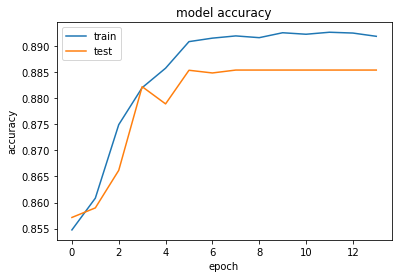

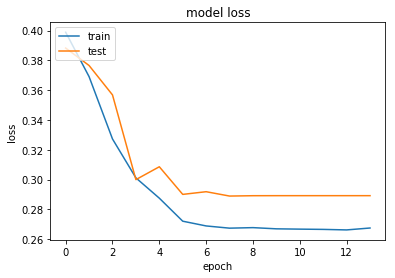

In [39]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()